In [2]:
import os
import pickle
import scipy
import scipy.io as sio
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat 

matplotlib.rcParams.update({'font.size': 18, 'figure.figsize': (16, 8)})
from behavenet import get_user_dir, make_dir_if_not_exists
from behavenet.data.utils import get_transforms_paths
from behavenet.data.utils import load_labels_like_latents
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example
from behavenet.plotting.arhmm_utils import *

from torch import nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler


In [3]:
latents_path = get_user_dir('data') + '/dipoppa/MSP_pupil/MD0ST5/4/cond-ae-msp/conv/09_latents/latent_search/version_0/dipoppa_MSP_pupil_MD0ST5_4_latents.pkl'

with open(latents_path, 'rb') as f:
    data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/home/samsung_2tb_ssd/yoni/data/dipoppa/MSP_pupil/MD0ST5/4/cond-ae-msp/conv/09_latents/latent_search/version_0/dipoppa_MSP_pupil_MD0ST5_4_latents.pkl'

In [161]:
latents = data['latents']

In [162]:
latents[5].shape

(150, 9)

In [163]:
def load_file(file, key=None):
    if not os.path.exists(file):
        raise FileNotFoundError(file + ' does not exist.')

    data = None
    if file.endswith('.npy'):
        data = np.load(file, allow_pickle=True).item()
    elif file.endswith('.mat'):
        data = loadmat(file)

    if key:
        try:
            data = data.get(key)
        except ValueError:
            print('File: ' + file + ' does not contain index: ' + key)

    return data

def load_data(session_id):

    expt_id = '2018-04-04_{}_MD0ST5'.format(session_id)
    root = os.getcwd() + '/../neural_dir'

    # Neural data
    all_neural = load_file(root + '/neural_activity' + expt_id + '.mat', key='neural_activity') 
    info_cells = load_file(root + '/info_cells_MD0ST5_2018-04-04.mat', key='info_cells')

    # Behavioral data
    behavioral_data = load_file(root + '/facemap/MD0ST5/sess_{}/'.format(session_id) + expt_id + '_eye_proc.npy')
    running_raw = load_file(root + '/running_speed' + expt_id + '.mat', key='running_speed')

    # Sequencing data
    bni = load_file(root + '/batch_neural_id' + expt_id + '.mat', key='batch_neural_id')
    bvi = load_file(root + '/batch_video_id' + expt_id + '.mat', key='batch_video_id')
    
    
    return all_neural, info_cells, behavioral_data, running_raw, bni, bvi

In [164]:
neural_sess_id = '4'
all_neural, info_cells, behavioral_data, running_raw, bni, bvi = load_data(neural_sess_id)
pupil_area = behavioral_data['pupil'][0]['area_smooth'][bvi[0][0]:bvi[1][-1]]

In [165]:
# Z-score neural data and load it into batches

def zscore(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

neural_transformed = zscore(all_neural)

In [166]:
batches = [neural_transformed[bni[0][i]:bni[1][i] + 1] for i in range(bni.shape[1])]

In [167]:
data_loader = DataLoader({'neural': batches, 'latents': latents}, batch_size=150)

In [168]:
train_batches = np.random.choice(365, int(365*0.8), replace=False)
test_batches = np.delete(np.arange(0, 365), train_batches)


In [169]:
# Creating data indices for training and validation splits:
dataset = {'neural': batches, 'latents': latents}

validation_split = .2
shuffle_dataset = True
random_seed = 42
batch_size = 150

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [170]:
class LatentDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_idx, n_lags=4):
        super().__init__()
        
        self.conv = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=n_lags * 2 + 1,  # window around t
            padding=n_lags)  # same output
        
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
        
        self.n_lags = n_lags
        
        self.latent_idx = latent_idx
        
    def forward(self, x):
        x = self.conv(x.transpose(1, 0).unsqueeze(0)).squeeze().transpose(1, 0)
        x = self.activation(x)
        y = self.output(x)
        
        return y

In [207]:
latent_idx = 7
model = LatentDecoder(all_neural.shape[1], 32, latent_idx)
model.to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
        model.parameters(), lr=0.001, weight_decay=0.001,
        amsgrad=True)
mean_train_latents = 0

# Train model
num_epochs = 10
for epoch in range(num_epochs):
    loss_val = 0
    for i, batch_idx in enumerate(train_batches):
        model.train()
        optimizer.zero_grad()
    
        neural = dataset['neural'][batch_idx]
        if not dataset['latents'][batch_idx].size:
            continue
            
        latents = torch.tensor(dataset['latents'][batch_idx][:, latent_idx]).reshape(-1, 1).to('cuda')
        mean_train_latents += torch.mean(latents)
        
        data = torch.tensor(neural).to('cuda')
        predictions = model(data)
        
        loss = criterion(predictions[model.n_lags:-model.n_lags], latents[model.n_lags:-model.n_lags])
        loss.backward()
        
        if epoch > 0:
                optimizer.step()

        loss_val += loss.item()
        if i > 0 and i % 20 == 0:
            print('[Epoch %d, Iteration %d-%d], Total Loss: %.4f'% (epoch, i-20, i, loss_val / 20))
            loss_val = 0

[Epoch 0, Iteration 0-20], Total Loss: 0.2567
[Epoch 0, Iteration 20-40], Total Loss: 0.2499
[Epoch 0, Iteration 40-60], Total Loss: 0.1718
[Epoch 0, Iteration 60-80], Total Loss: 0.2267
[Epoch 0, Iteration 80-100], Total Loss: 0.2132
[Epoch 0, Iteration 100-120], Total Loss: 0.2097
[Epoch 0, Iteration 120-140], Total Loss: 0.2444
[Epoch 0, Iteration 140-160], Total Loss: 0.2760
[Epoch 0, Iteration 160-180], Total Loss: 0.2673
[Epoch 0, Iteration 180-200], Total Loss: 0.1673
[Epoch 0, Iteration 200-220], Total Loss: 0.2458
[Epoch 0, Iteration 220-240], Total Loss: 0.2623
[Epoch 0, Iteration 240-260], Total Loss: 0.1886
[Epoch 0, Iteration 260-280], Total Loss: 0.1744
[Epoch 1, Iteration 0-20], Total Loss: 1.9956
[Epoch 1, Iteration 20-40], Total Loss: 1.9361
[Epoch 1, Iteration 40-60], Total Loss: 2.4557
[Epoch 1, Iteration 60-80], Total Loss: 1.6776
[Epoch 1, Iteration 80-100], Total Loss: 2.1178
[Epoch 1, Iteration 100-120], Total Loss: 1.1815
[Epoch 1, Iteration 120-140], Total Loss

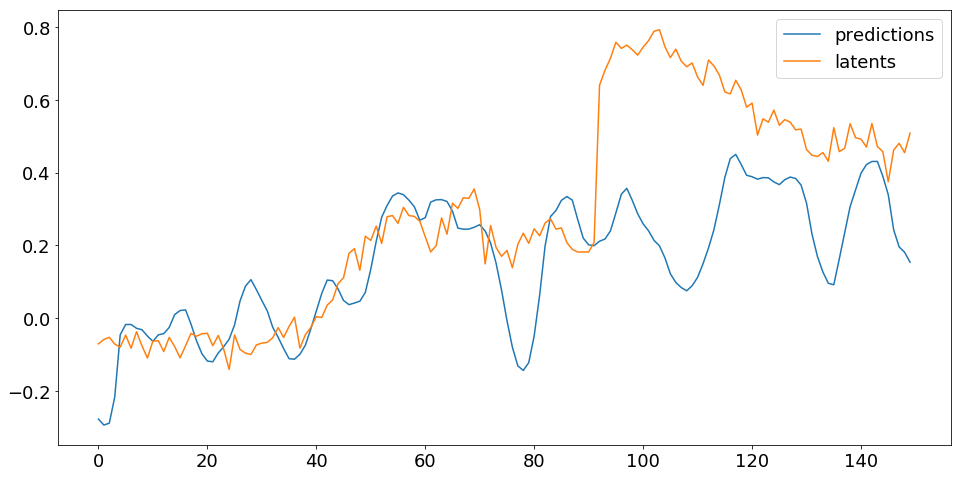

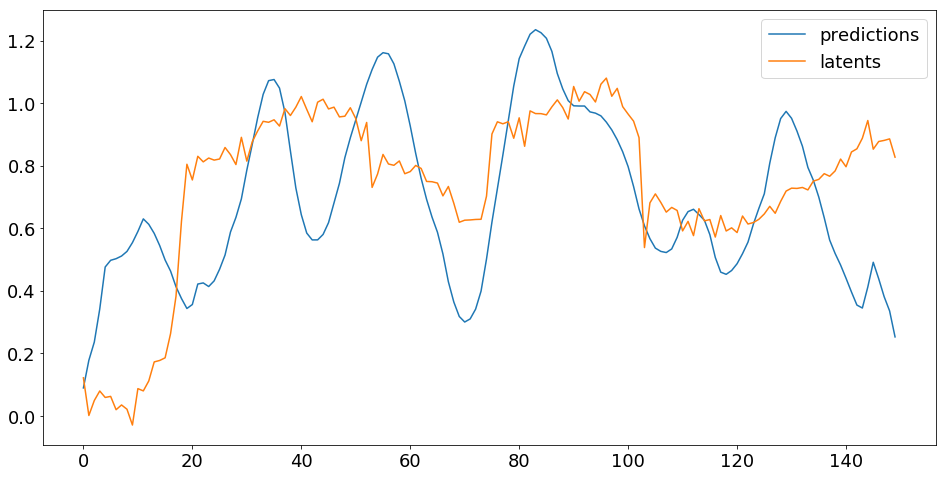

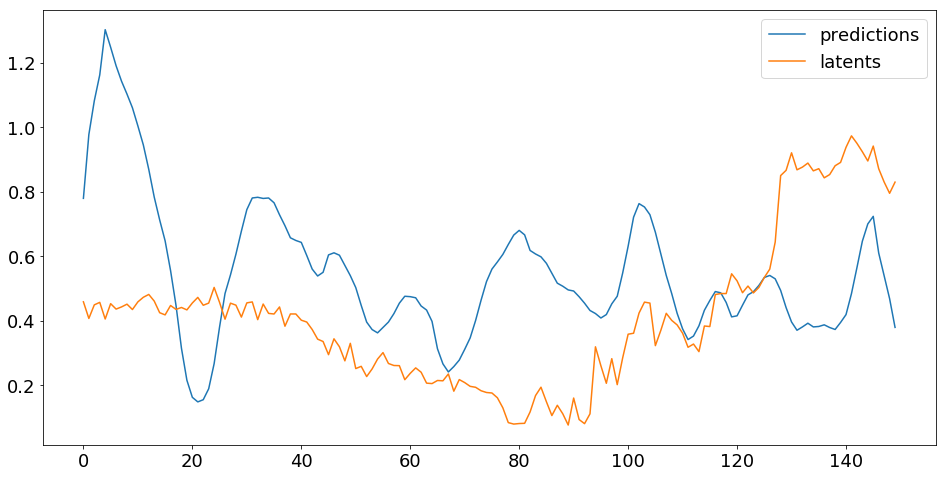

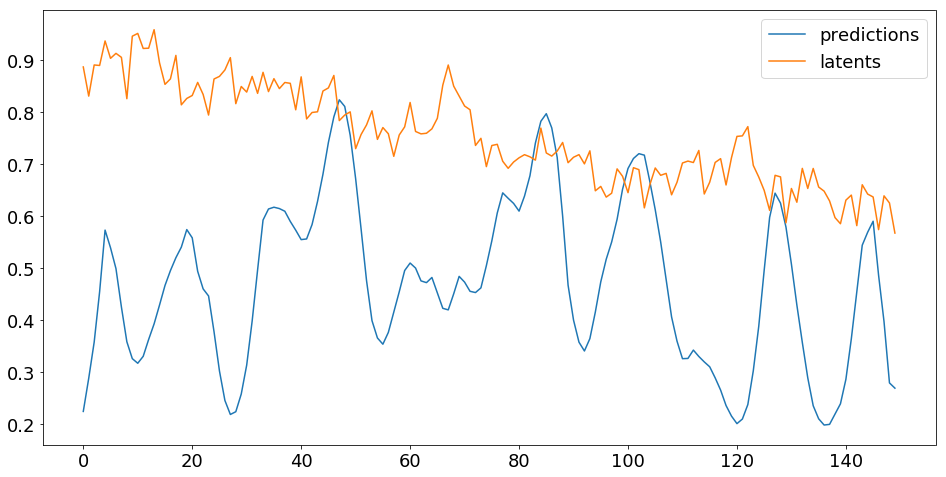

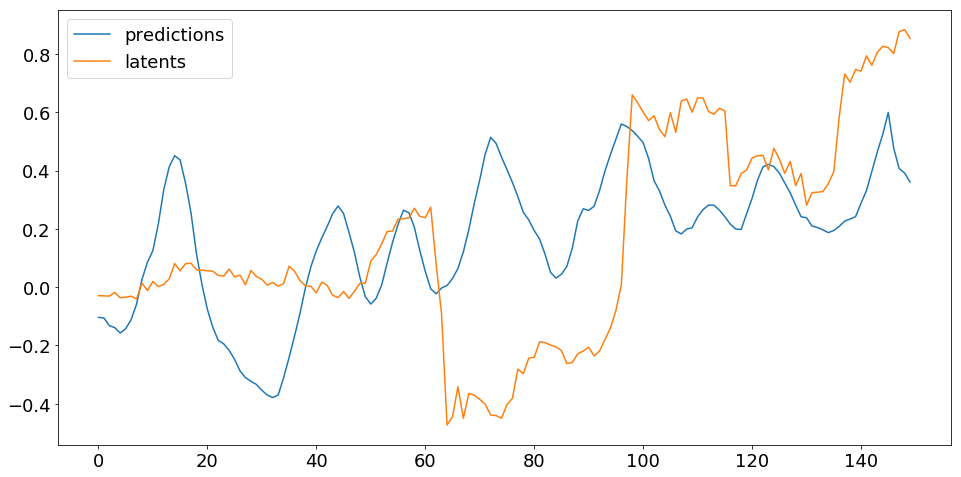

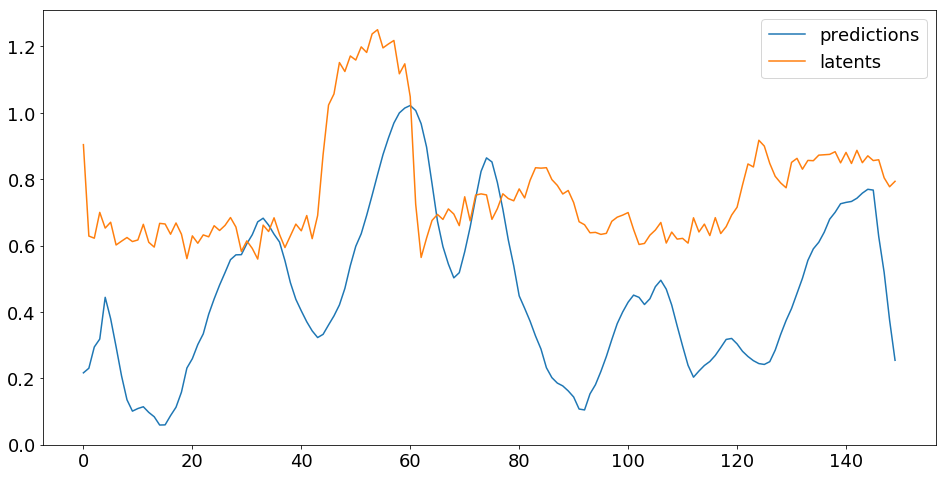

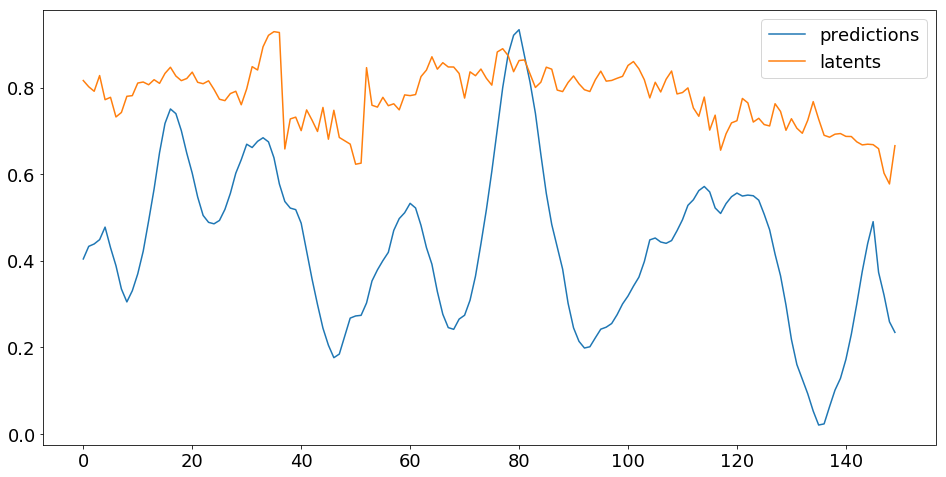

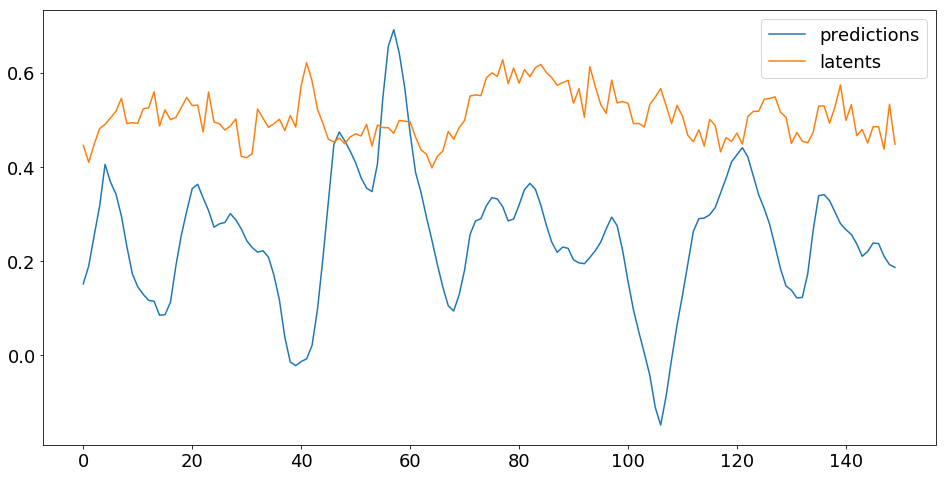

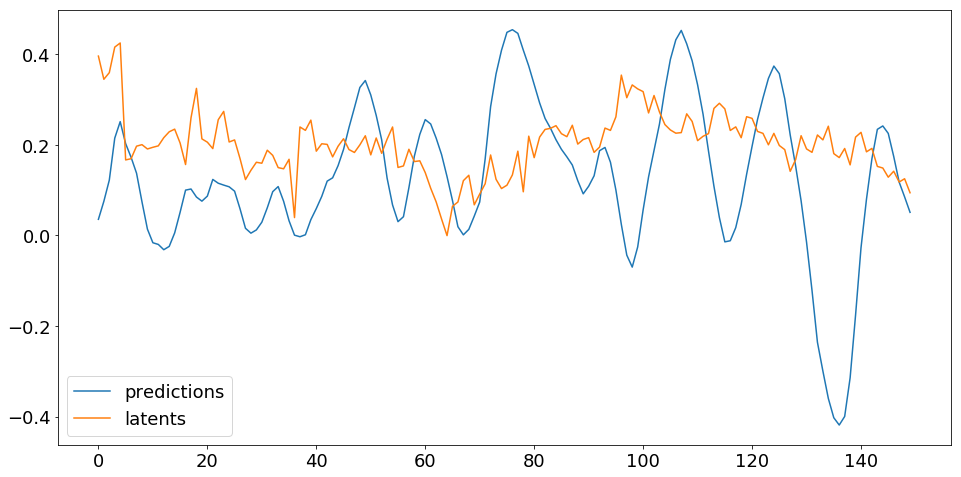

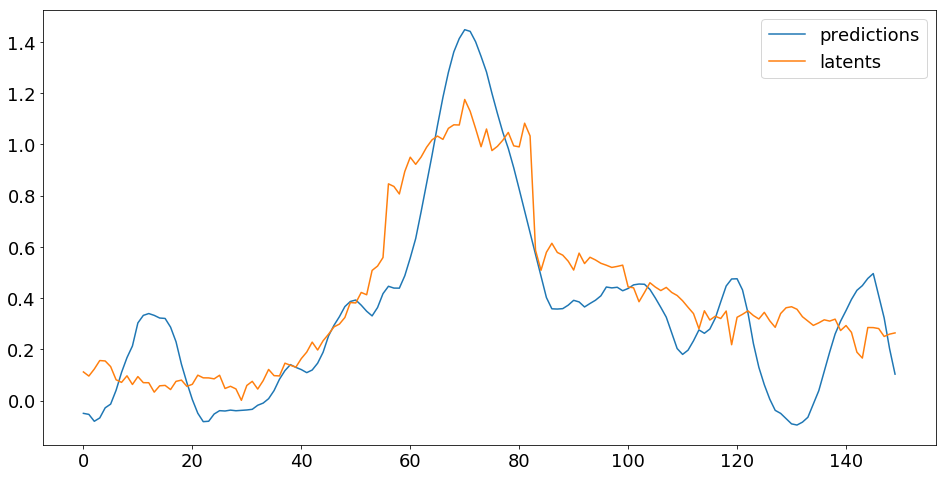

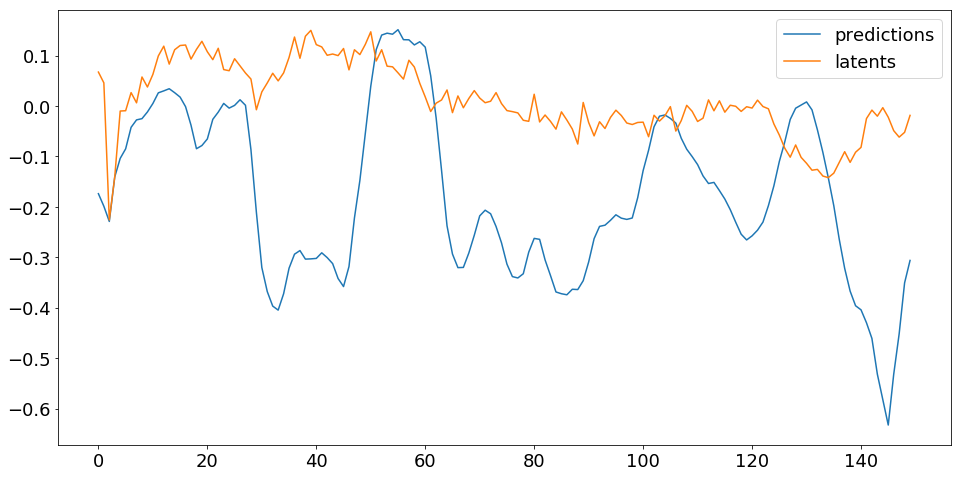

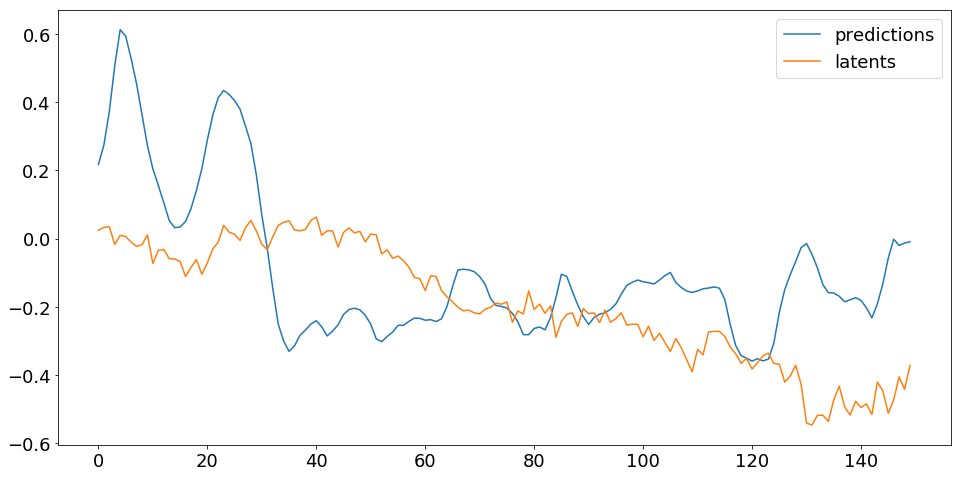

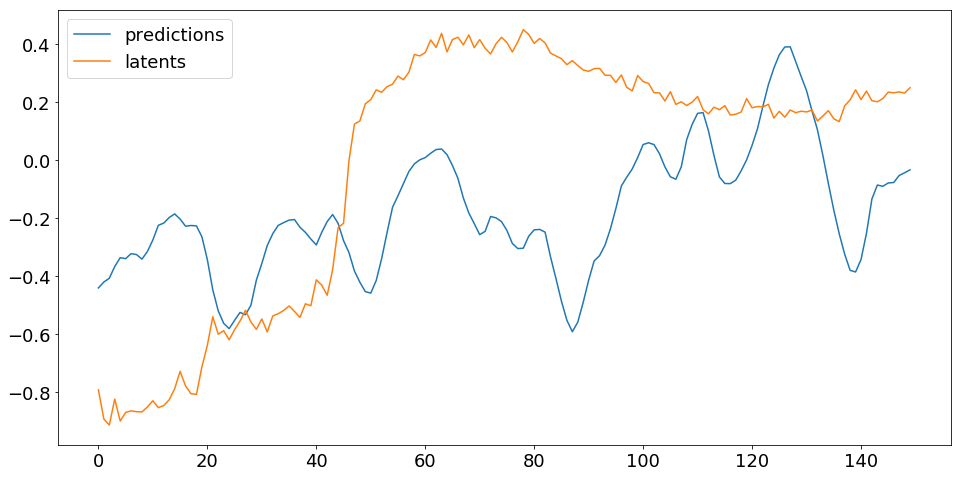

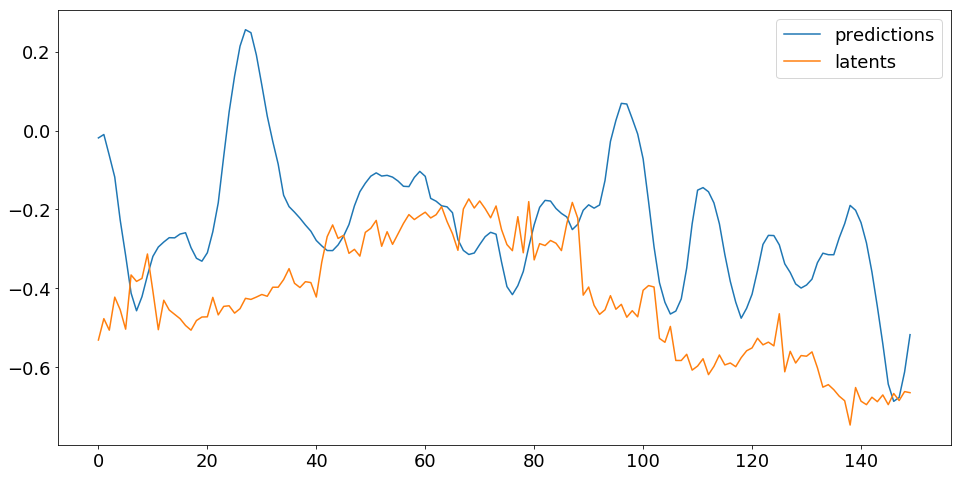

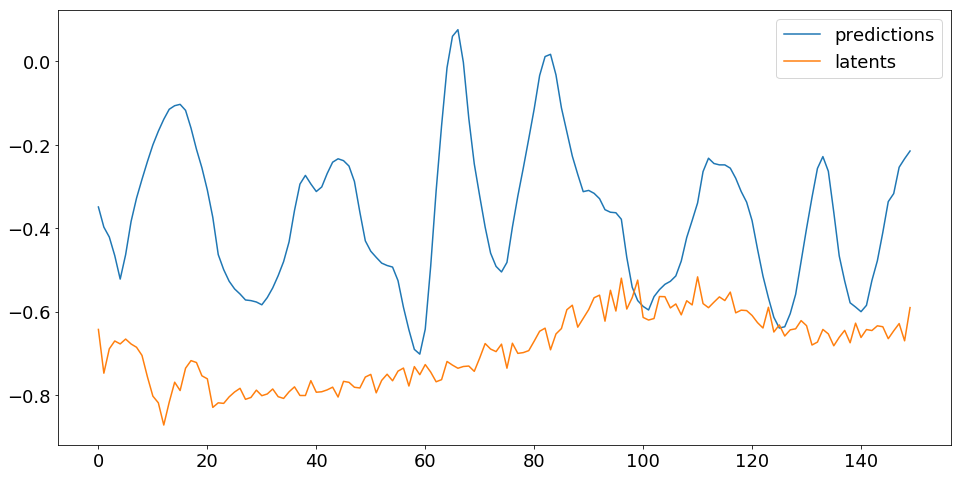

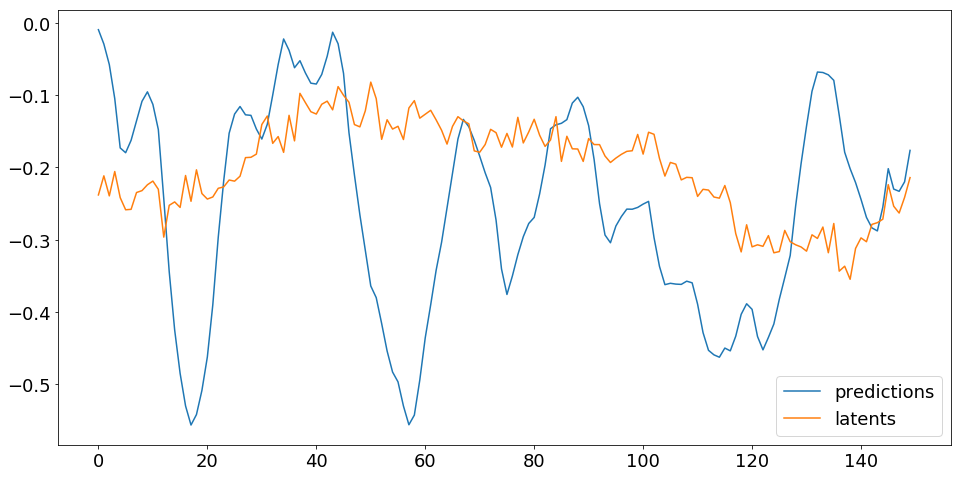

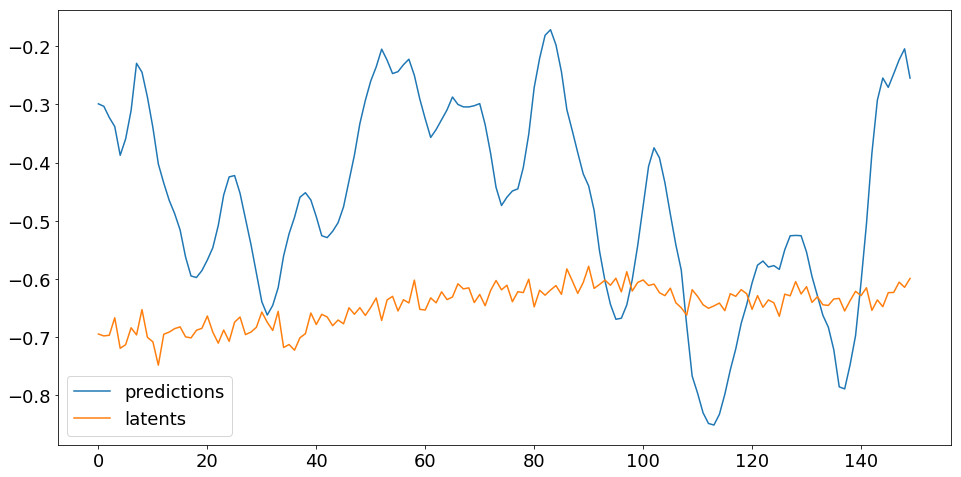

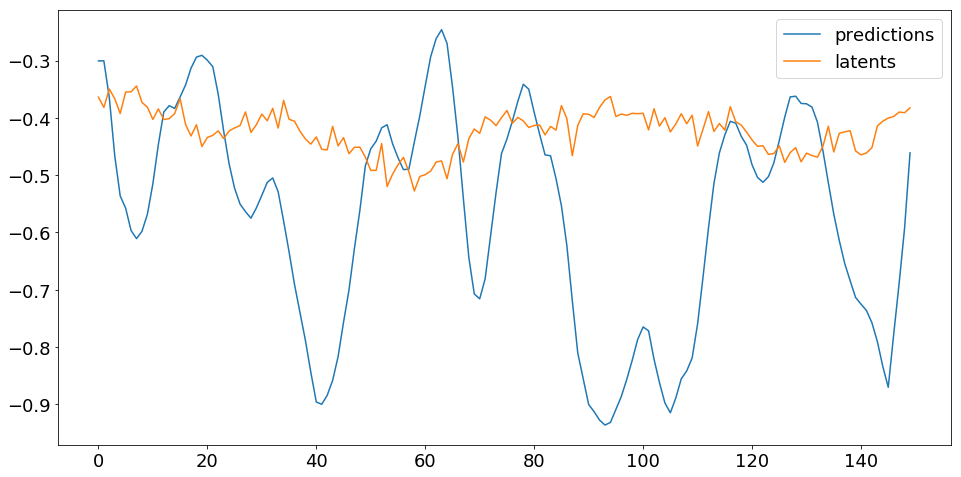

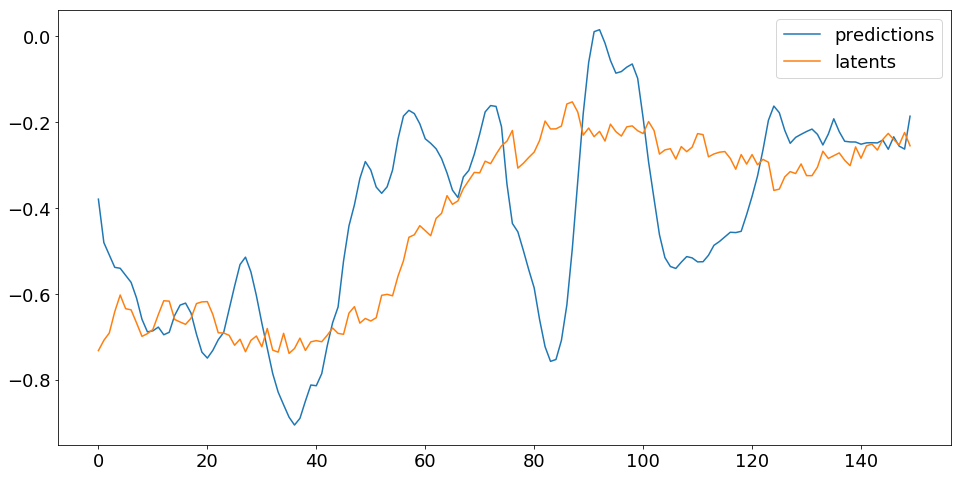

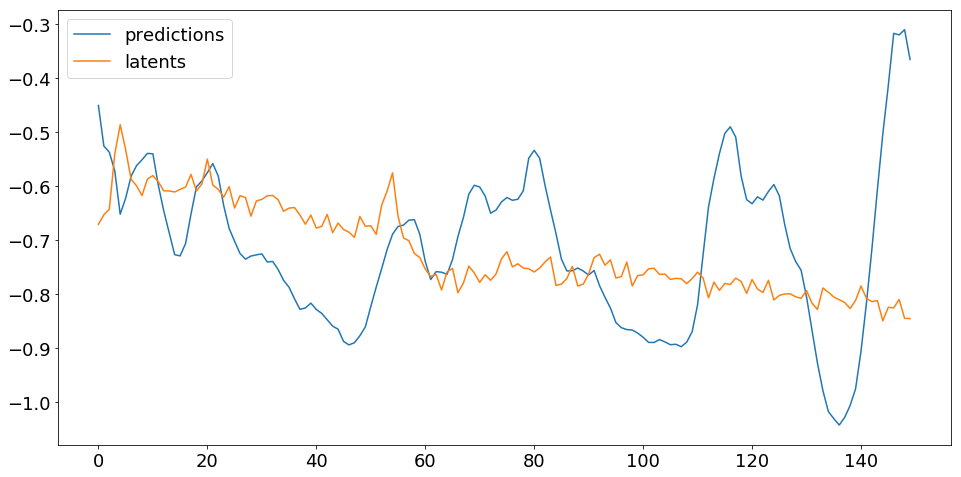

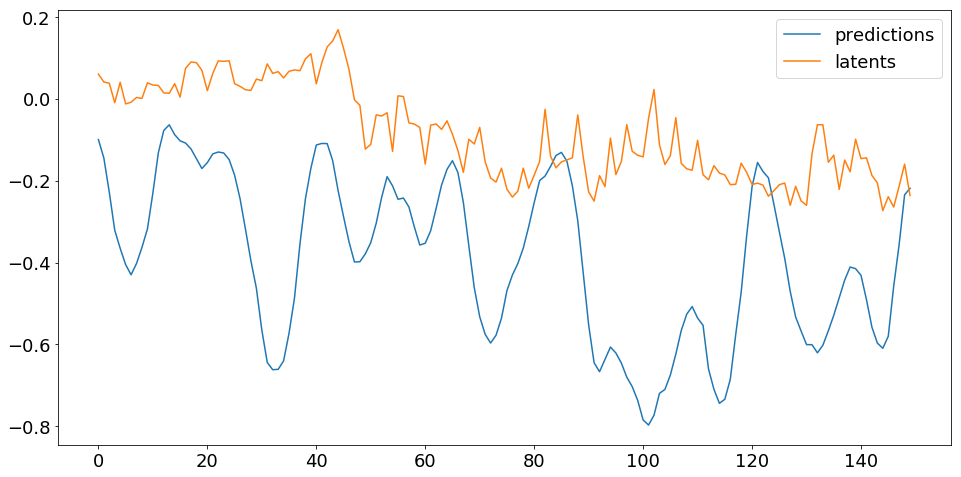

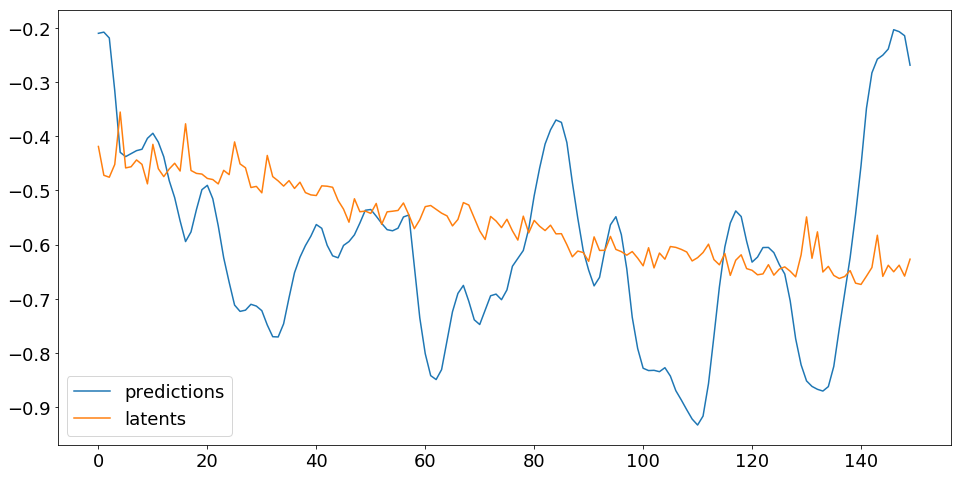

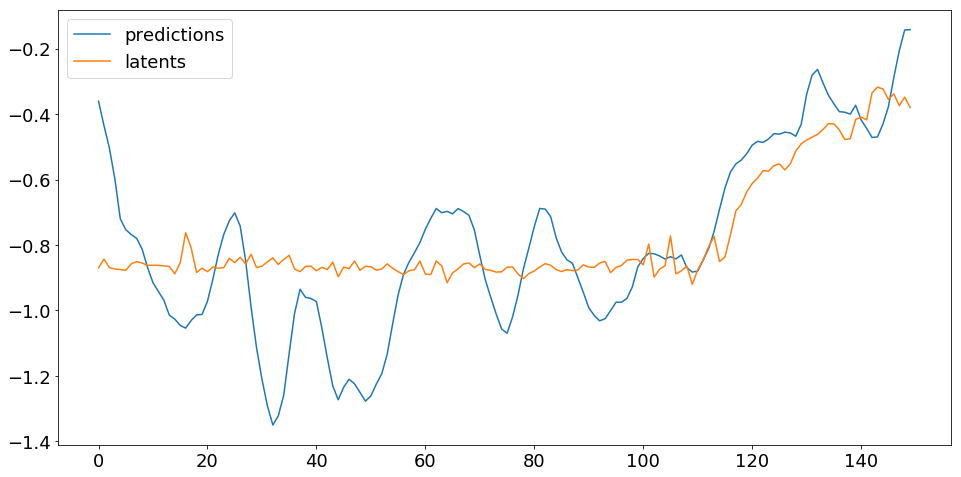

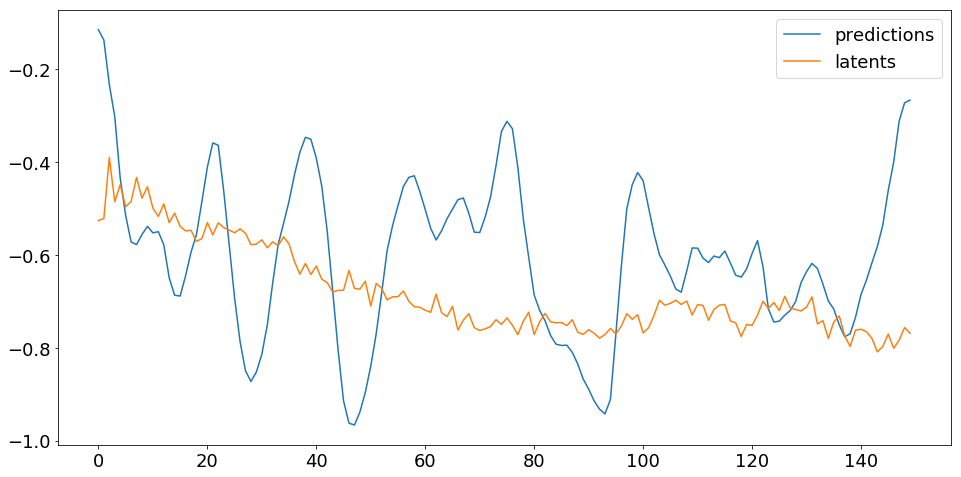

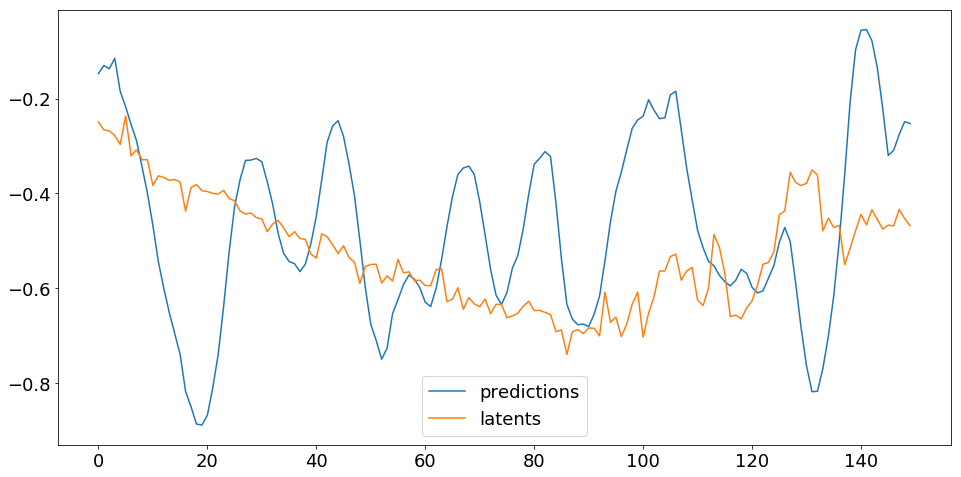

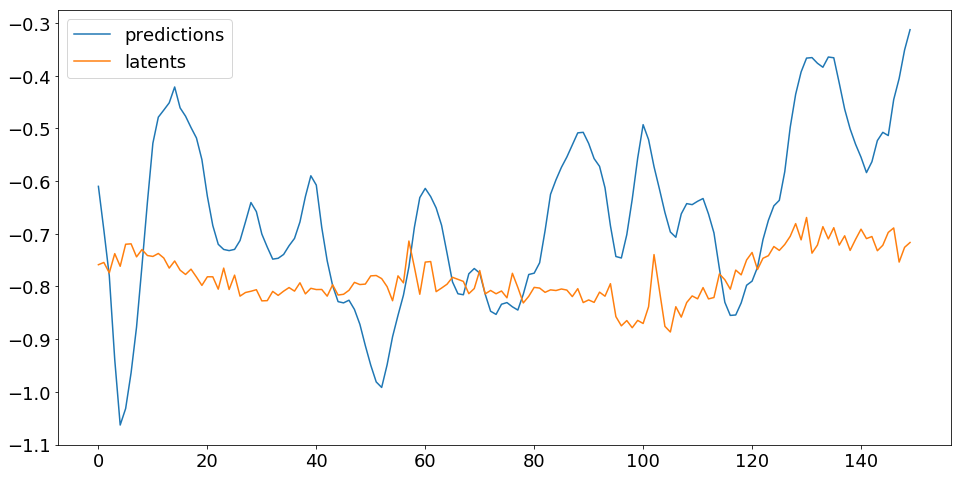

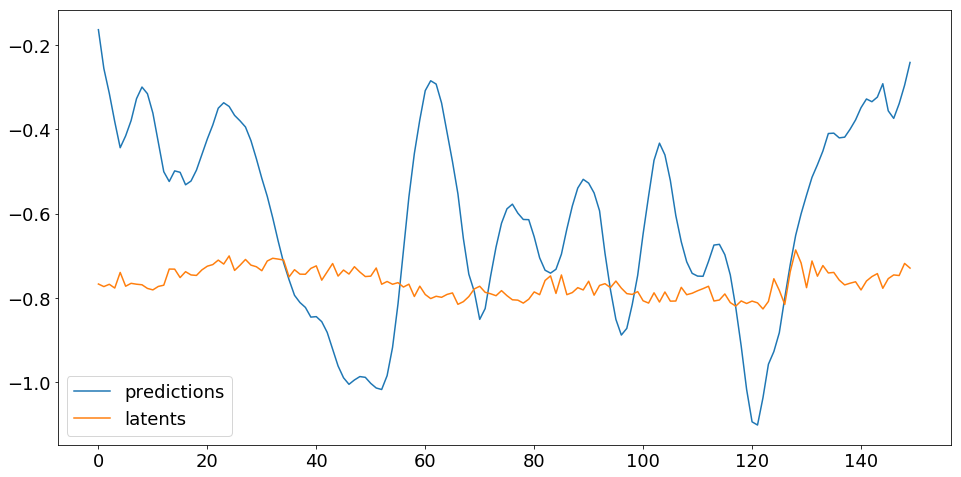

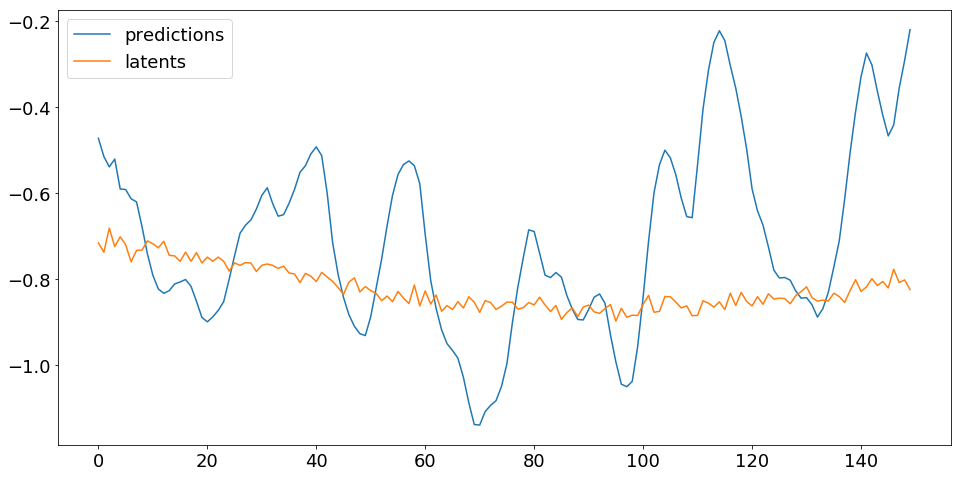

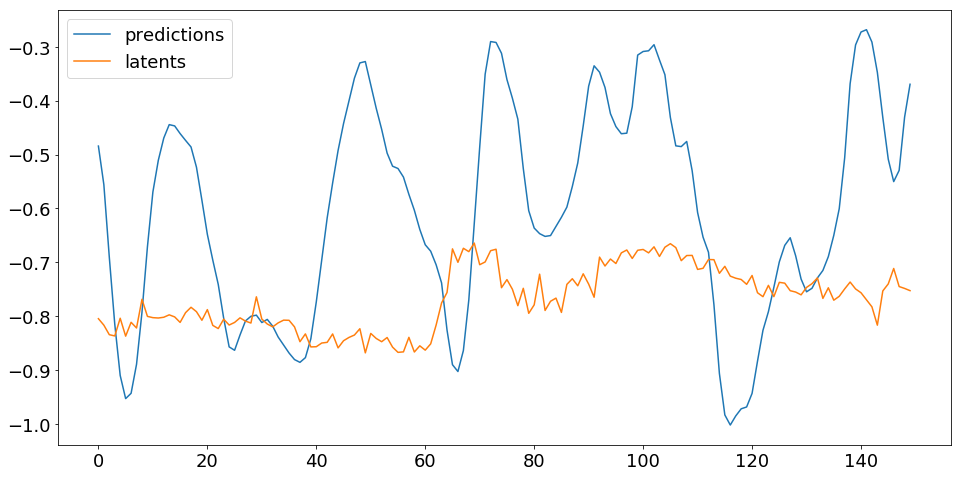

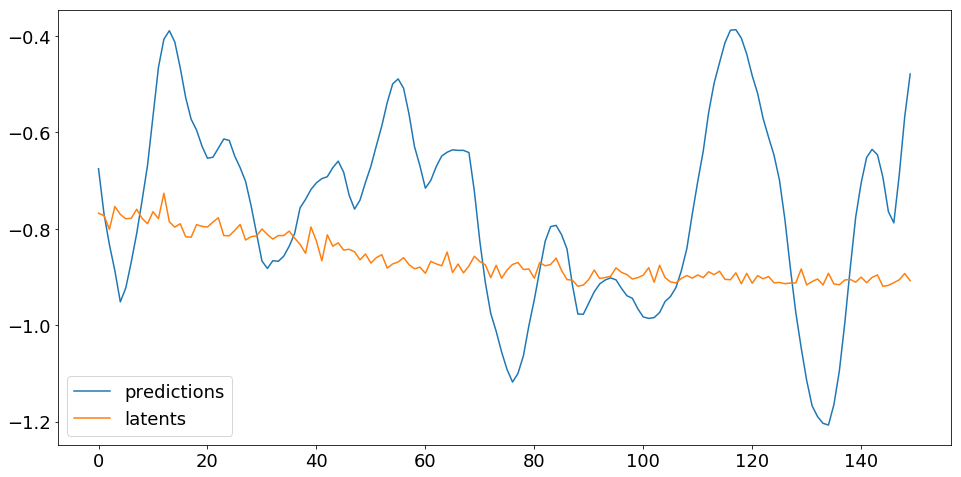

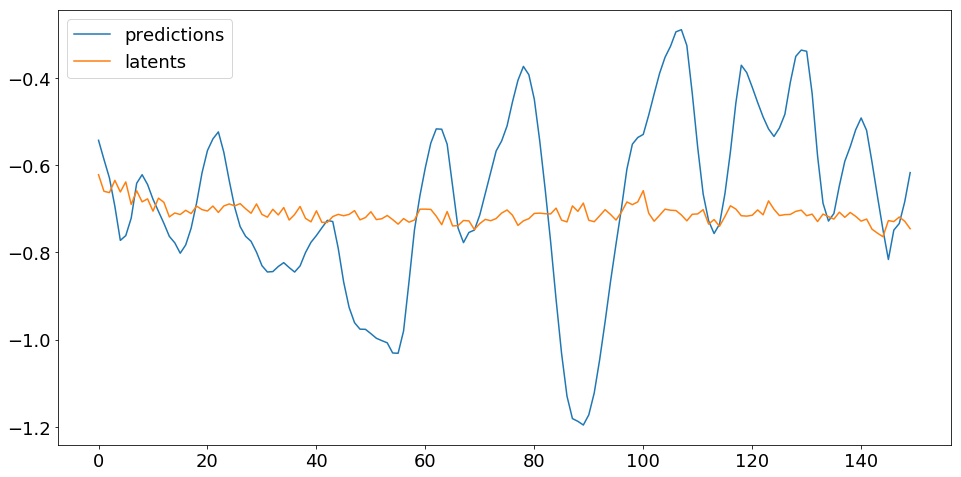

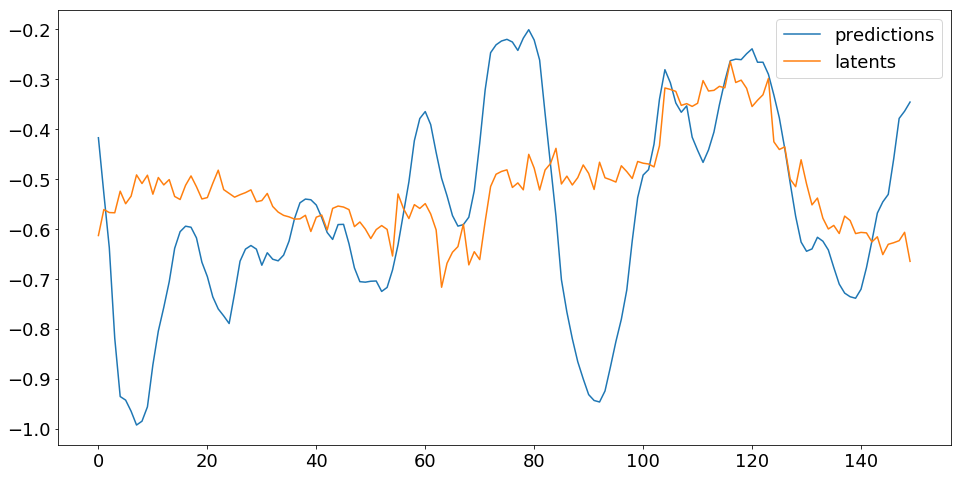

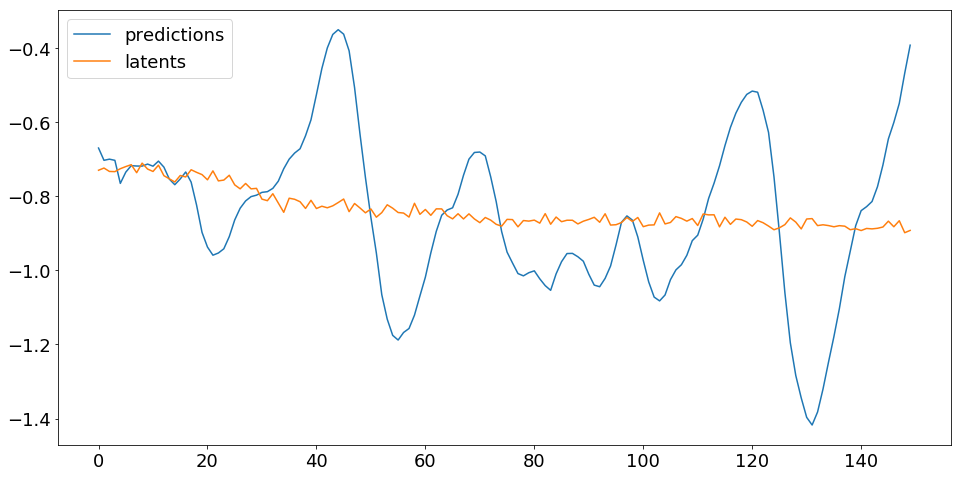

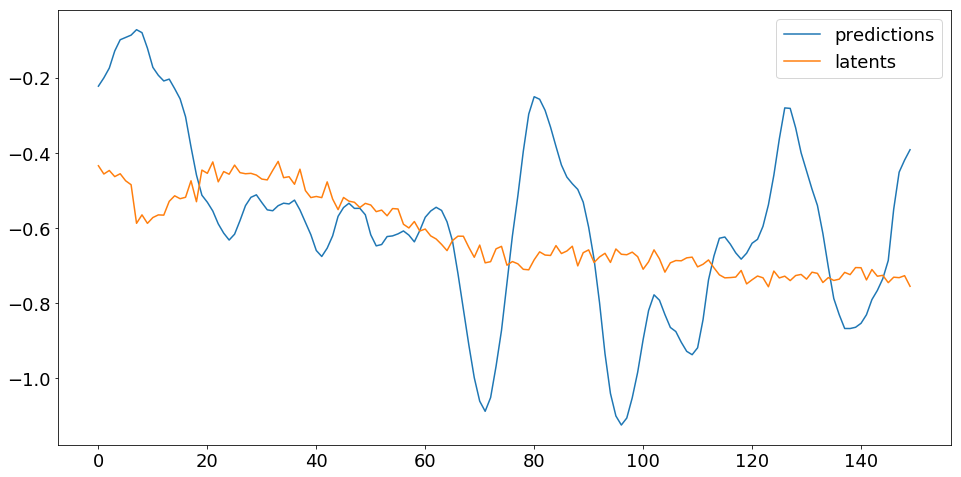

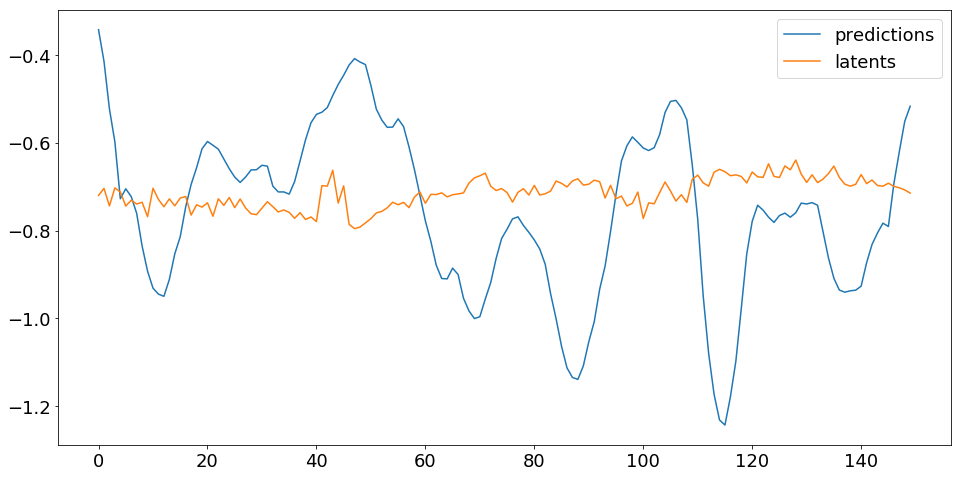

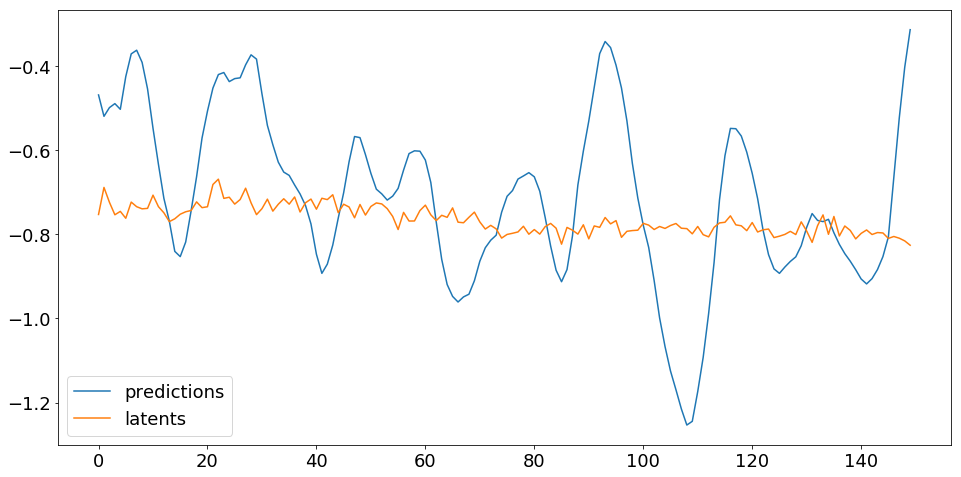

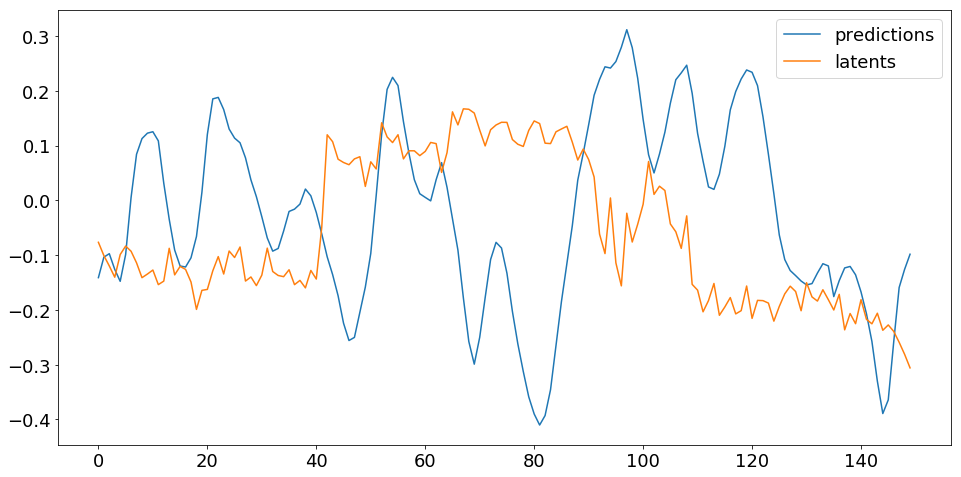

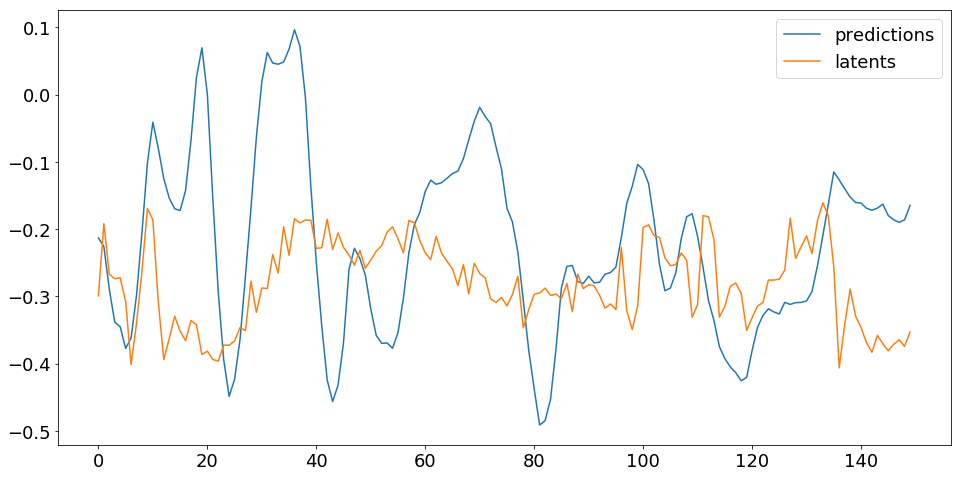

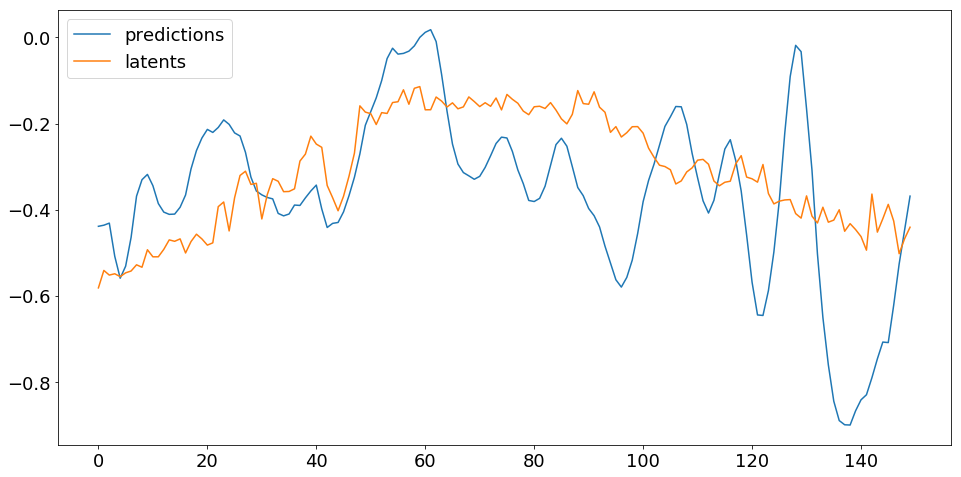

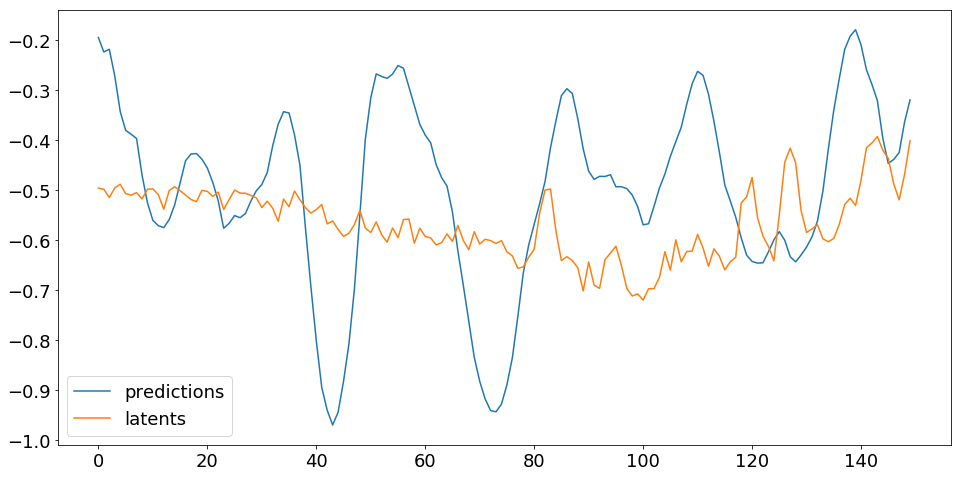

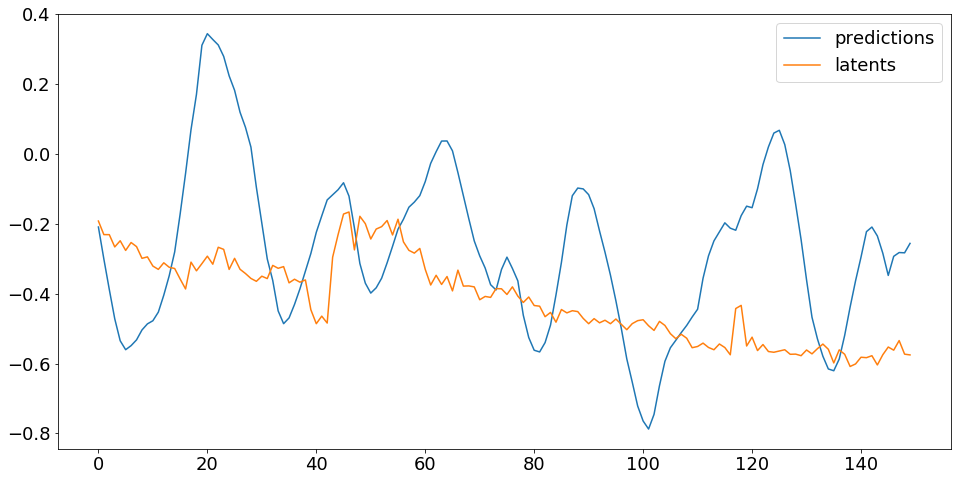

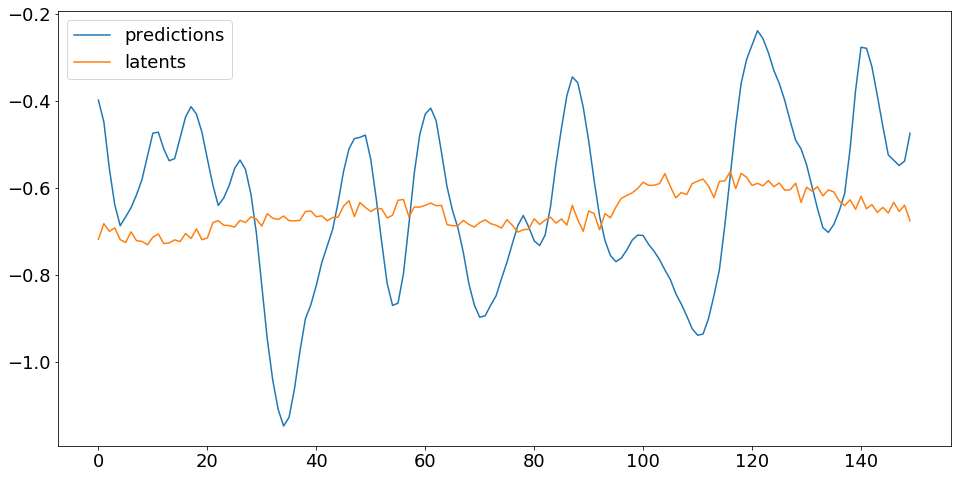

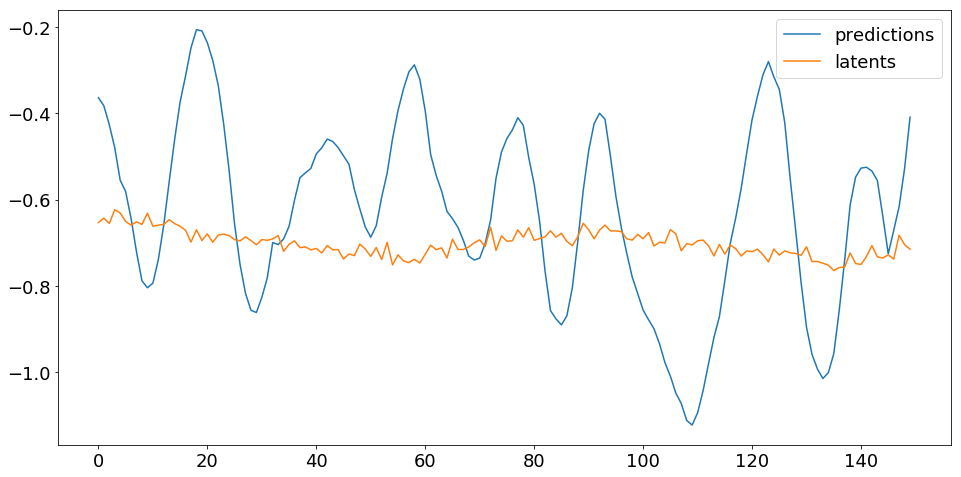

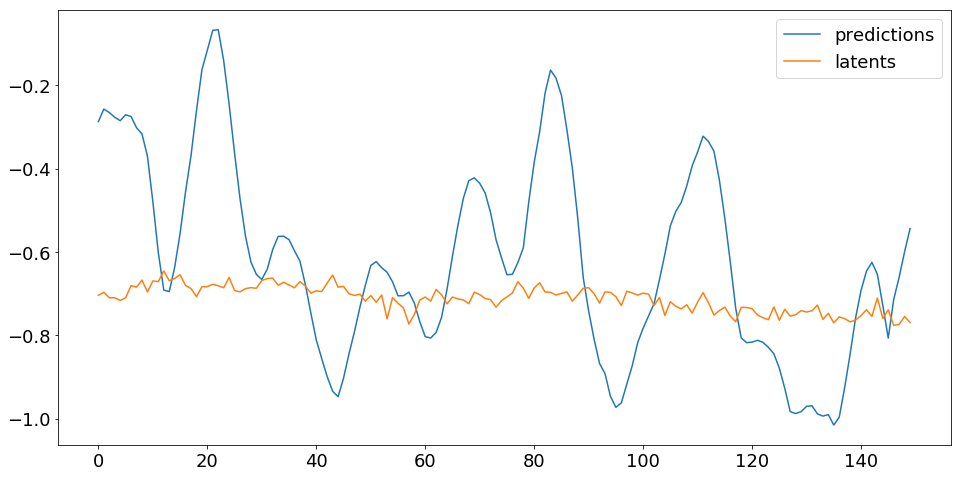

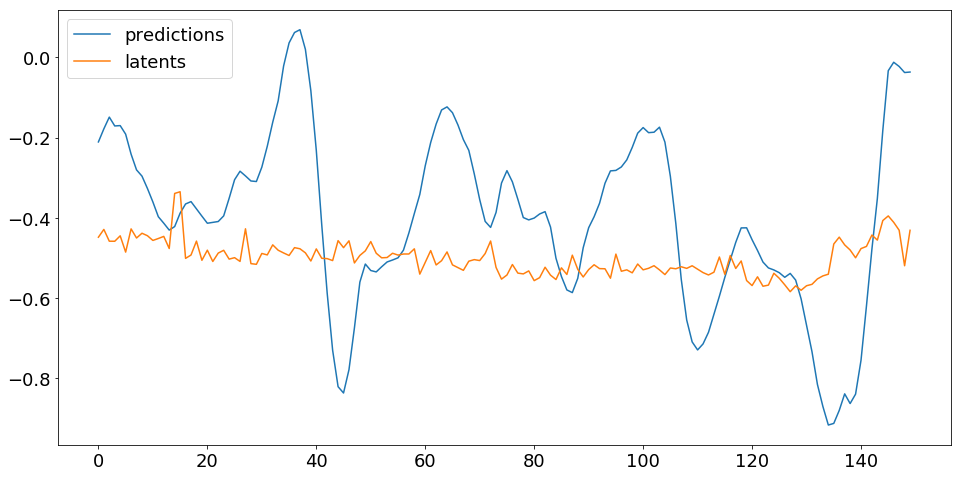

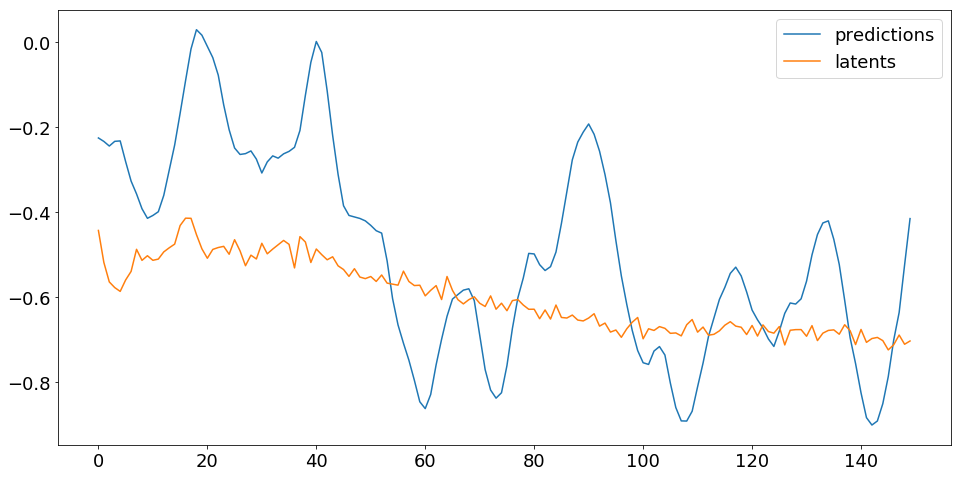

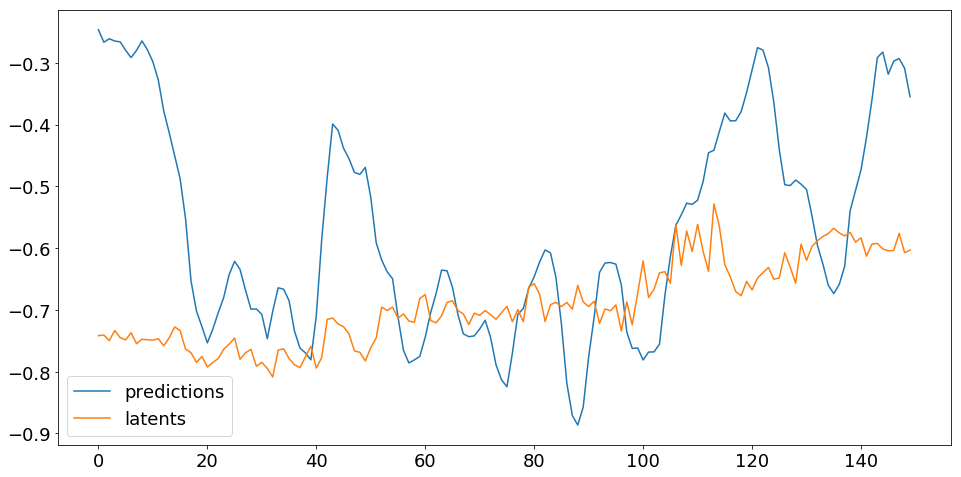

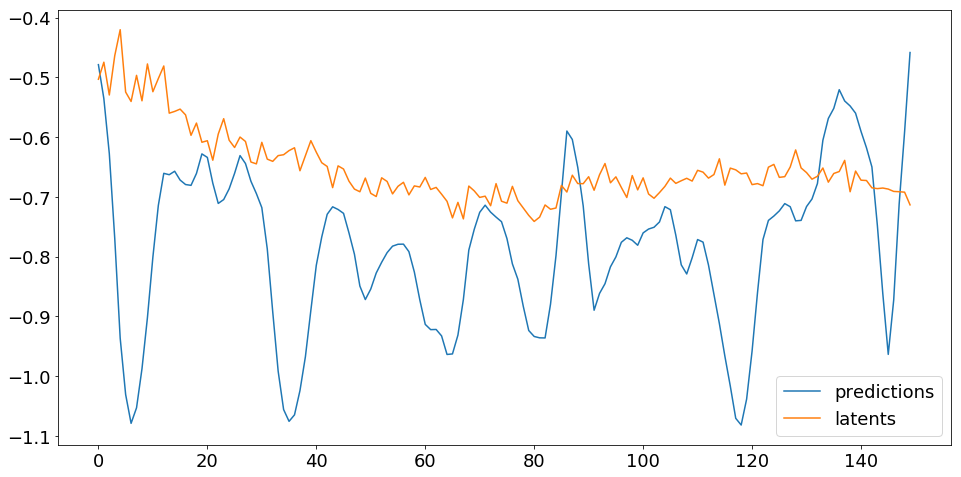

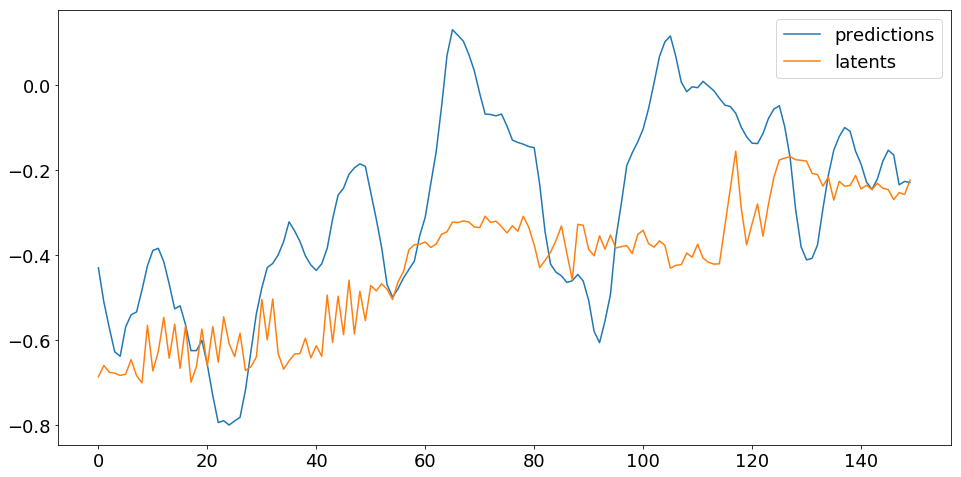

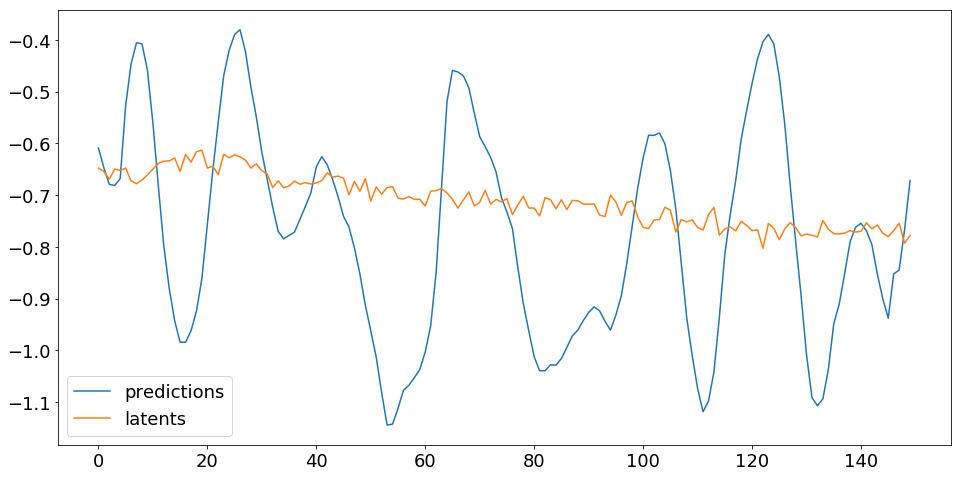

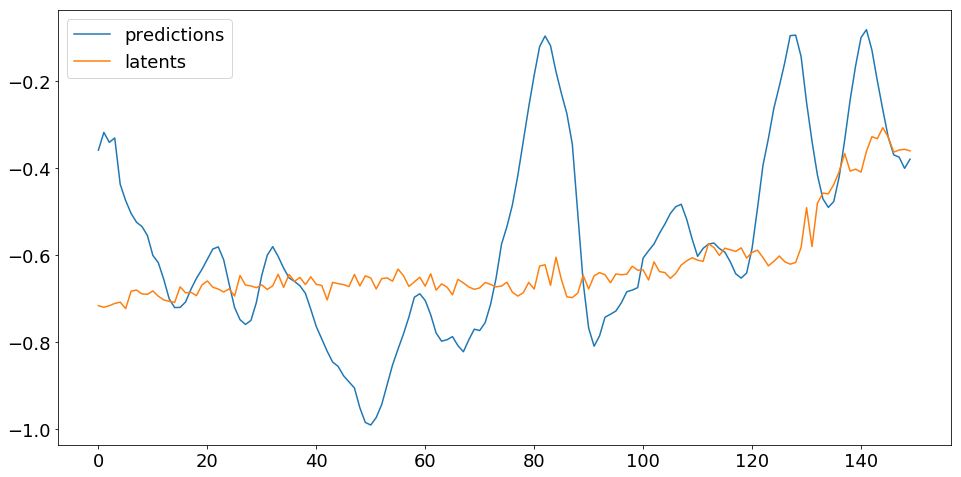

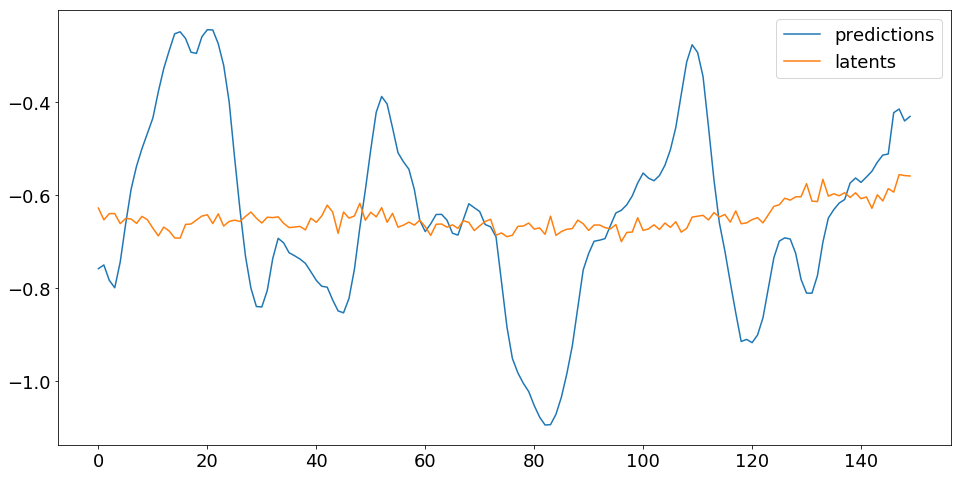

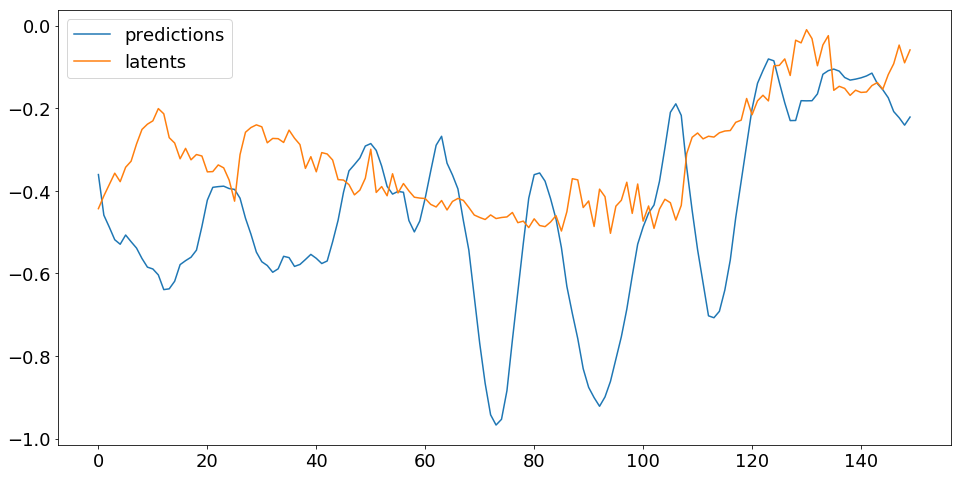

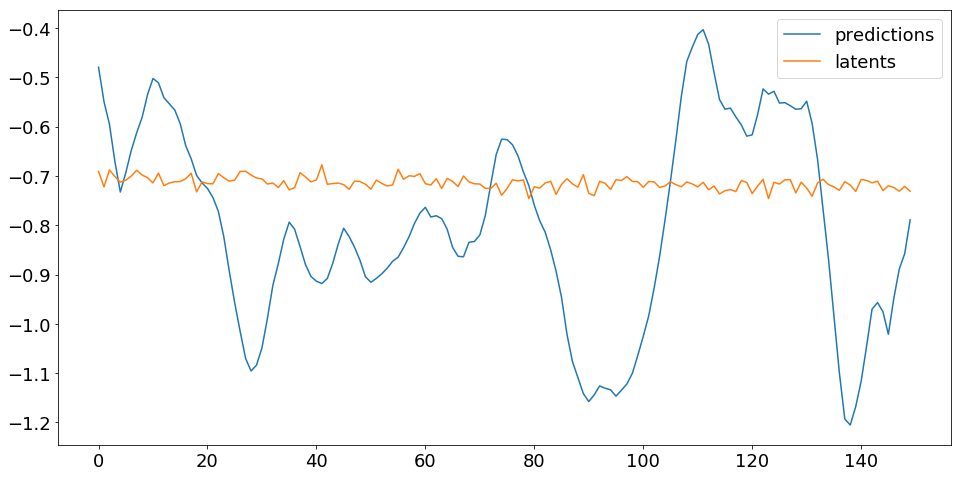

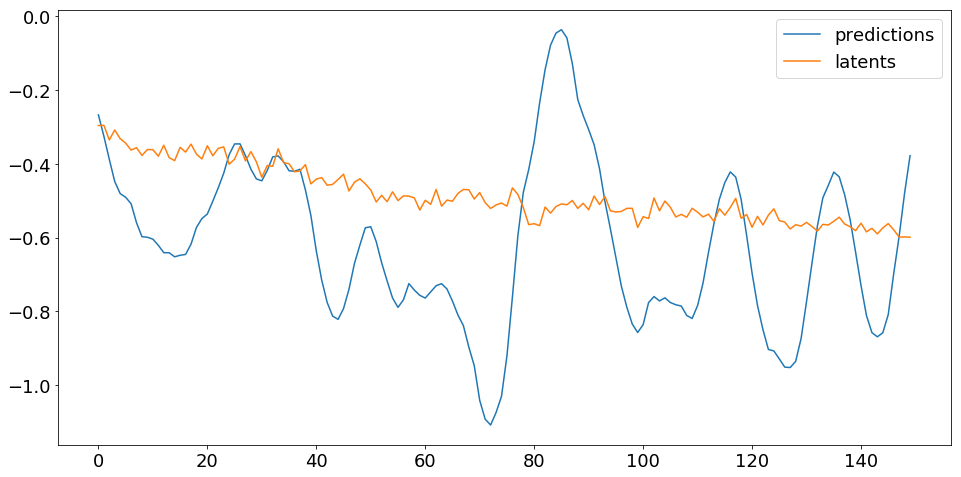

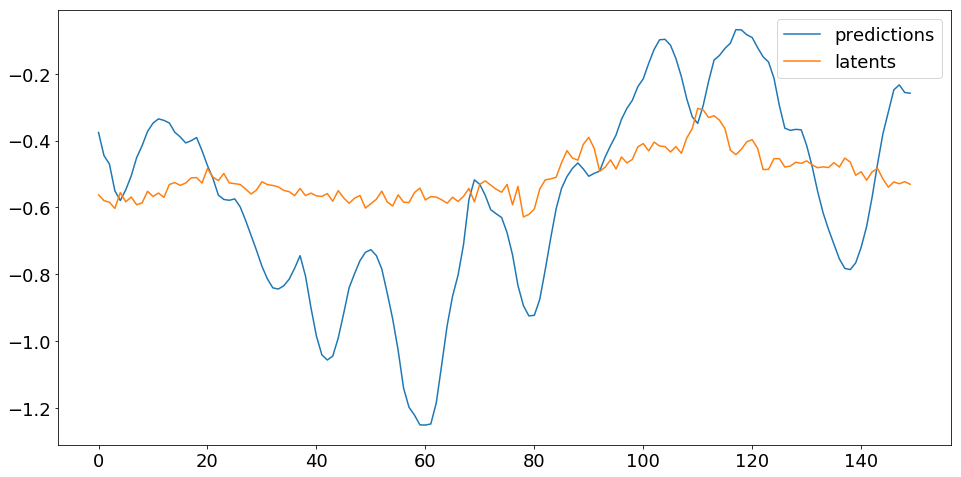

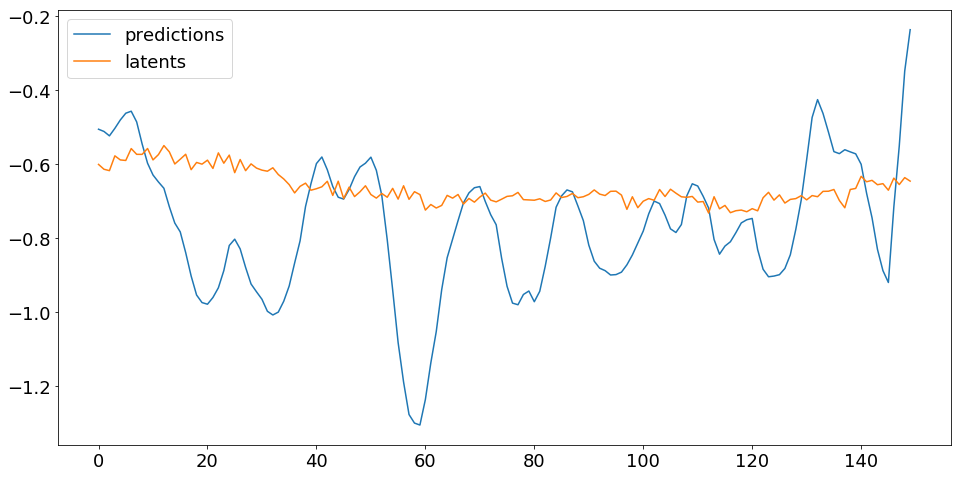

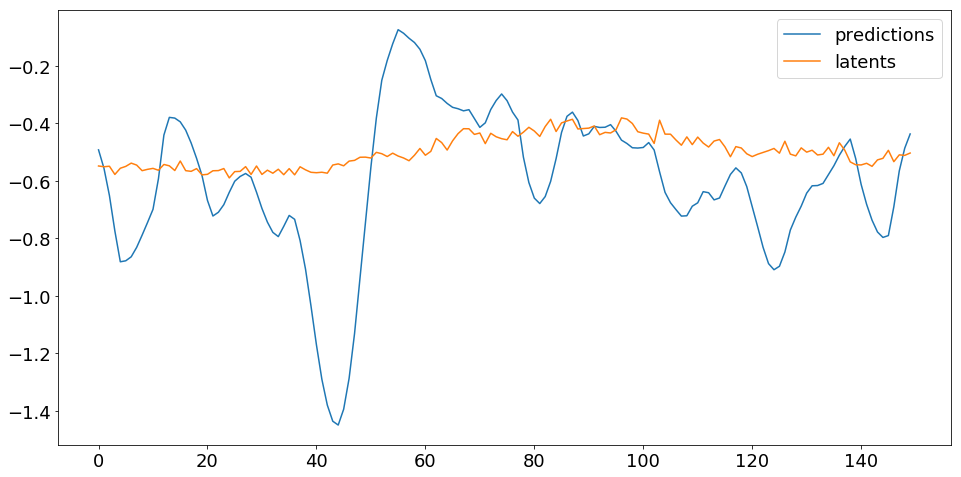

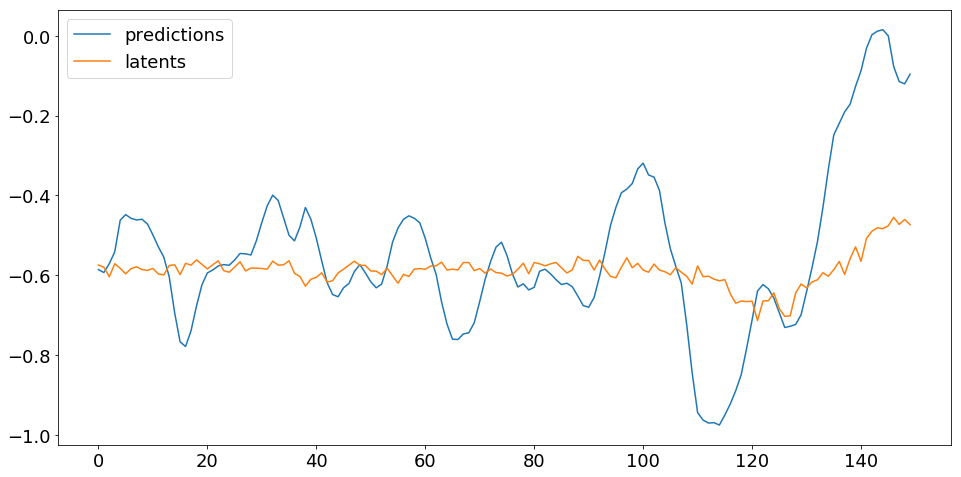

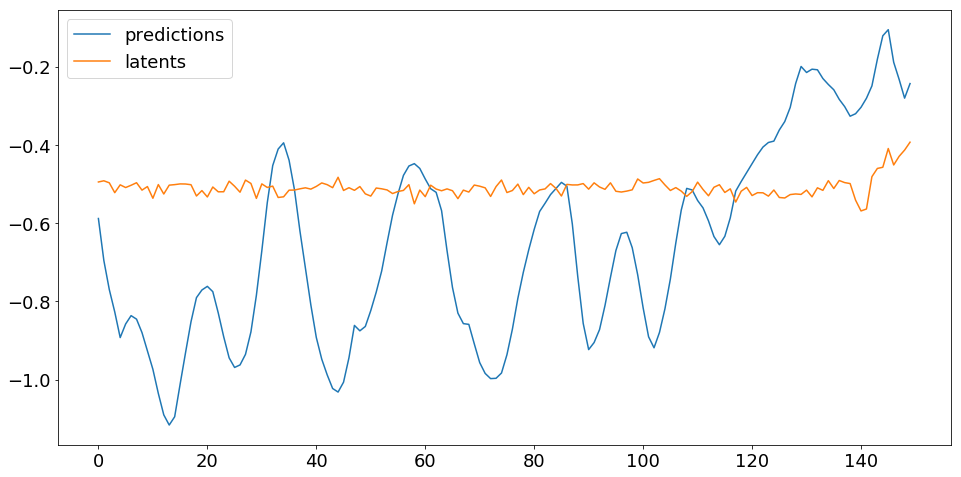

0.05077760366515981


329.6506767272949

In [214]:
model.eval()
avg_test_error = 0
model.to('cpu')
mean_test_error = 0 
for i, batch_idx in enumerate(test_batches):
    neural = dataset['neural'][batch_idx]
    if not dataset['latents'][batch_idx].size:
        continue

    targets = torch.tensor(dataset['latents'][batch_idx][:, latent_idx]).reshape(-1, 1).numpy()
    data = torch.tensor(neural).to('cpu')
    predictions = model(data).detach().numpy()
    plt.plot(predictions, label='predictions')
    plt.plot(targets, label='latents')
    plt.legend()
    plt.show()
    avg_test_error += np.mean((targets[model.n_lags:-model.n_lags] - predictions[model.n_lags:-model.n_lags])**2)
    mean_test_error += np.mean((targets[model.n_lags:-model.n_lags] - (mean_train_latents.cpu().numpy() / len(train_batches))) ** 2)
avg_test_error /= i
print(avg_test_error)
mean_test_error

In [209]:
np.mean(latents[61].cpu().numpy())

-0.6390379